In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

In [10]:
# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

from utils.topic_comparison import compare_topic_queryset, save_res, sort_matrix, draw_score_matrix
from utils.topic_comparison import save_topic_list_as_table, draw_bipartite_topic_graph, bipartite_graph_from_matrix

Topic Model Run

In [3]:
user1, created =  User.objects.get_or_create(username='leey', email='lee@mcc-berlin.net')
user1.save()

In [4]:
# simple search for utterances
par_search_tei, created = pm.Search.objects.get_or_create(
                title="Kohle tei utterance",
                text="kohle",
                creator=user1,
                document_source="GermaParlTEI",
                search_object_type=2)
par_search_tei.save()
if created:
    print("doing search")
do_search(par_search_tei.id)
print(par_search_tei.par_count)
print(par_search_tei.utterance_count)
print(par_search_tei.runstats_set.all())

3281 utterances with search kohle
35275
3281
35275
3281
<QuerySet [<RunStats: RunStats object (1099)>, <RunStats: RunStats object (1069)>, <RunStats: RunStats object (1110)>, <RunStats: RunStats object (1070)>, <RunStats: RunStats object (1100)>, <RunStats: RunStats object (1080)>, <RunStats: RunStats object (1101)>, <RunStats: RunStats object (1081)>, <RunStats: RunStats object (1062)>, <RunStats: RunStats object (1082)>, <RunStats: RunStats object (1061)>, <RunStats: RunStats object (1093)>, <RunStats: RunStats object (1094)>, <RunStats: RunStats object (1108)>, <RunStats: RunStats object (1063)>, <RunStats: RunStats object (1083)>, <RunStats: RunStats object (1045)>, <RunStats: RunStats object (1109)>, <RunStats: RunStats object (1095)>, <RunStats: RunStats object (1046)>, '...(remaining elements truncated)...']>


Changing alpha

In [5]:
K = 30

In [6]:
#run_tm.delay(par_search_tei.id, K, method='LD', alpha=0.5)

<AsyncResult: 25984463-a630-4149-aede-b836a89c0c14>

Stopwords

In [5]:
K = 40
# "standard" run = 1063

In [38]:
stopword1 = ['herr']
stopword2 = ['jahr']
stopword3 = ['mehr']
stopword123 = stopword1 + stopword2 + stopword3

nmf_word5 = ['deutschland', 'sag']
lda_word5 = ['jahr', 'herr', 'mehr', 'deutschland', 'sag', 'prozent', 'ganz', 'schon', 'land', 'neu', 'bundesregier', 'europa', 'polit', 'deutsch', 'frag'] 

In [30]:
for stopword in stopword123:
    run_tm.delay(par_search_tei.id, K, method='NM', extra_stopwords=[stopword])
    time.sleep(5)

In [43]:
run_tm.delay(par_search_tei.id, K, method='NM', extra_stopwords=stopword3)

<AsyncResult: 188042af-168f-4353-a85c-1b6b74dd541c>

## Bipartite Plots

### LDA

['run_1063_topics_40', 'scores_1063', 'similarity_1063-1116', 'run_1116_topics_40', 'scores_1116']
C2:C40
matching sum:	167.0
max rows:	186.0
max cols:	187.0


0

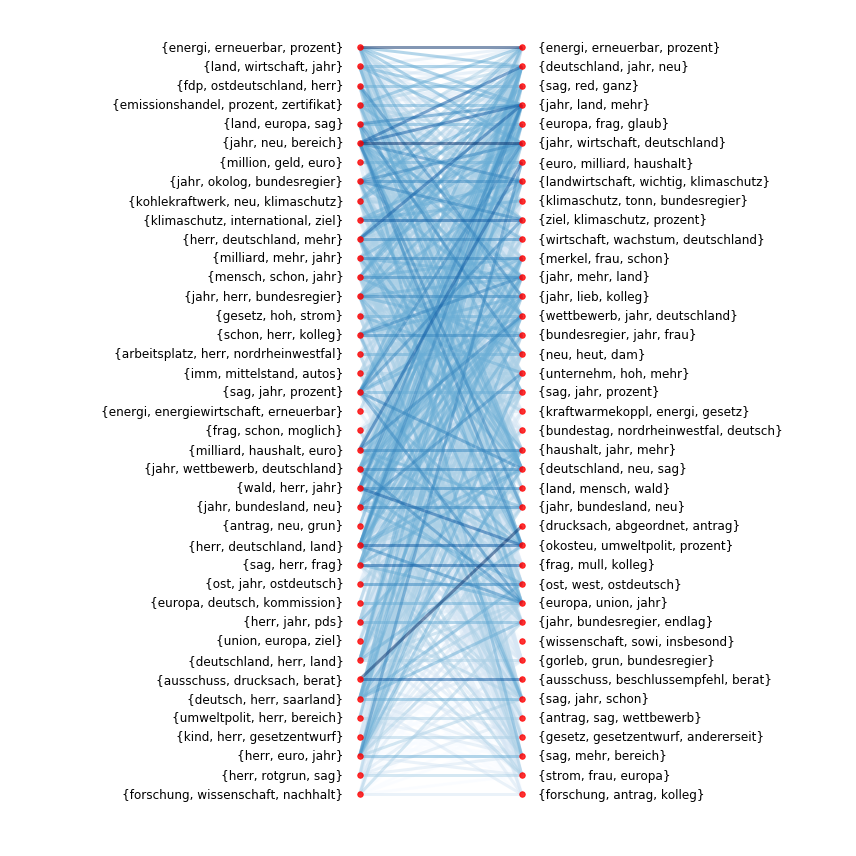

In [31]:
# LDA, stopword = 'herr'
run_id1 = 1063
run_id2 = 1116

topics1 = Topic.objects.filter(run_id=run_id1).order_by('-score')
topics2 = Topic.objects.filter(run_id=run_id2).order_by('-score')

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_Kohle_LD_K{}_stopword_{}_topword_score'.format(K, stopword1[0]))

['run_1063_topics_40', 'scores_1063', 'similarity_1063-1117', 'run_1117_topics_40', 'scores_1117']
C2:C40
matching sum:	174.0
max rows:	194.0
max cols:	193.0


0

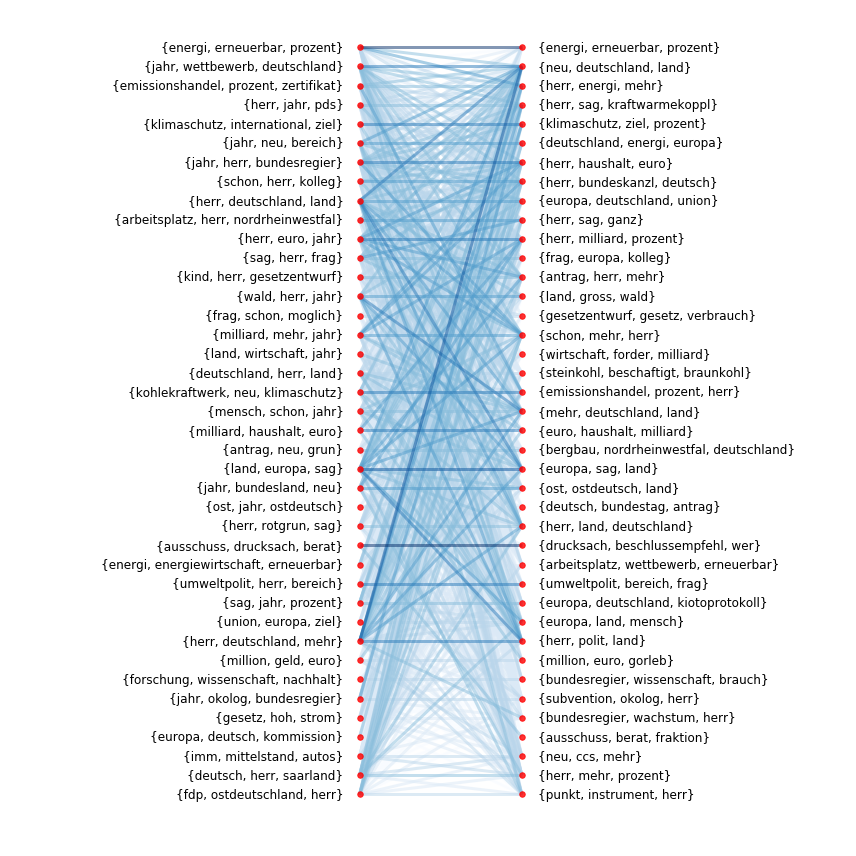

In [35]:
# LDA, stopword = 'jahr'
run_id1 = 1063
run_id2 = 1117

topics1 = Topic.objects.filter(run_id=run_id1).order_by('-score')
topics2 = Topic.objects.filter(run_id=run_id2).order_by('-score')

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_Kohle_LD_K{}_stopword_{}_topword_score'.format(K, stopword2[0]))

['run_1063_topics_40', 'scores_1063', 'similarity_1063-1118', 'run_1118_topics_40', 'scores_1118']
C2:C40
matching sum:	171.0
max rows:	189.0
max cols:	187.0


0

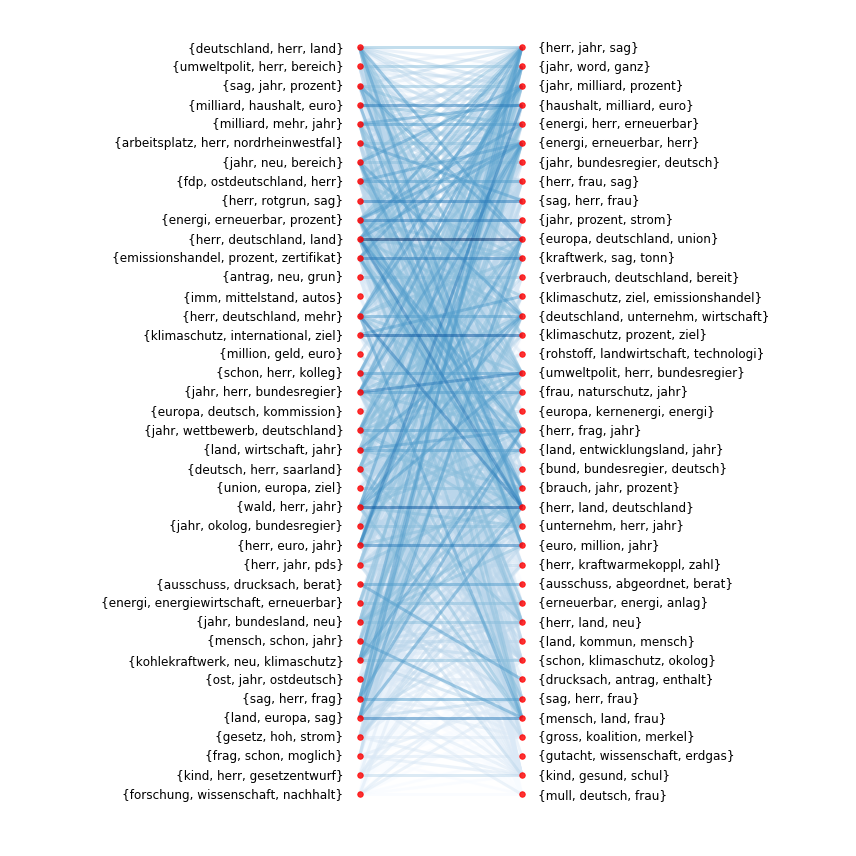

In [36]:
# LDA, stopword = 'mehr'
run_id1 = 1063
run_id2 = 1118

topics1 = Topic.objects.filter(run_id=run_id1).order_by('-score')
topics2 = Topic.objects.filter(run_id=run_id2).order_by('-score')

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_Kohle_LD_K{}_stopword_{}_topword_score'.format(K, stopword3[0]))

['run_1115_topics_40', 'scores_1115', 'similarity_1115-1063', 'run_1063_topics_40', 'scores_1063']
C2:C40
matching sum:	158.0
max rows:	177.0
max cols:	170.0


0

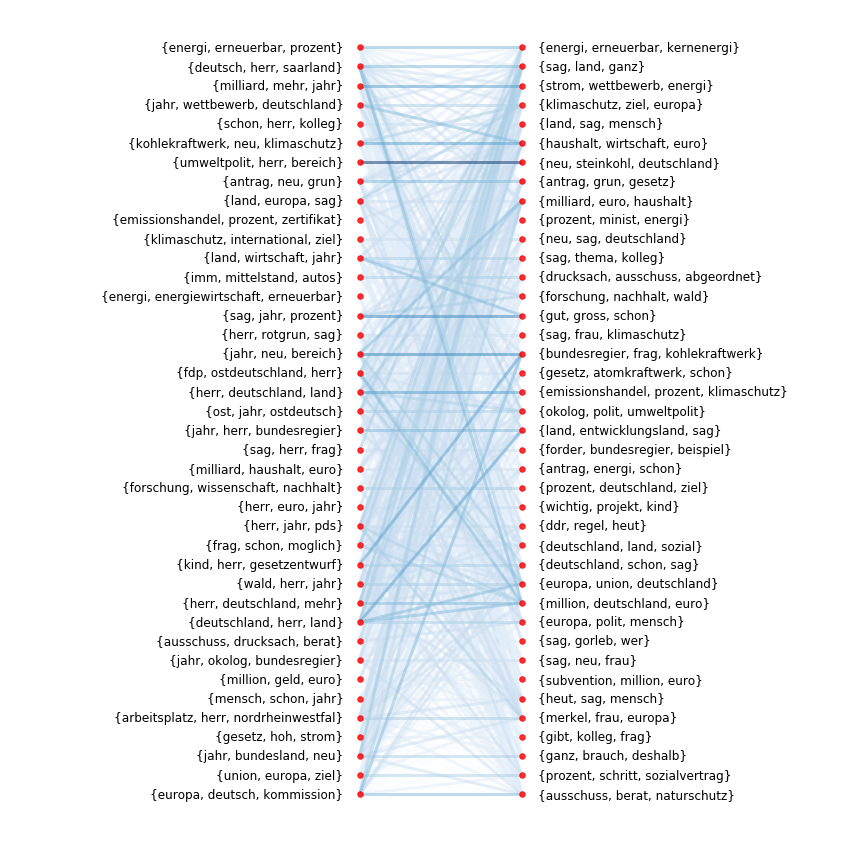

In [19]:
# LDA, stopword = 'herr', 'jahr', 'mehr'
run_id1 = 1063
run_id2 = 1115

topics1 = Topic.objects.filter(run_id=run_id1).order_by('-score')
topics2 = Topic.objects.filter(run_id=run_id2).order_by('-score')

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_Kohle_LD_K{}_stopword_{}_topword_score'.format(K, stopword123))

['run_1124_topics_40', 'scores_1124', 'similarity_1124-1063', 'run_1063_topics_40', 'scores_1063']
C2:C40
matching sum:	99.0
max rows:	113.0
max cols:	106.0


0

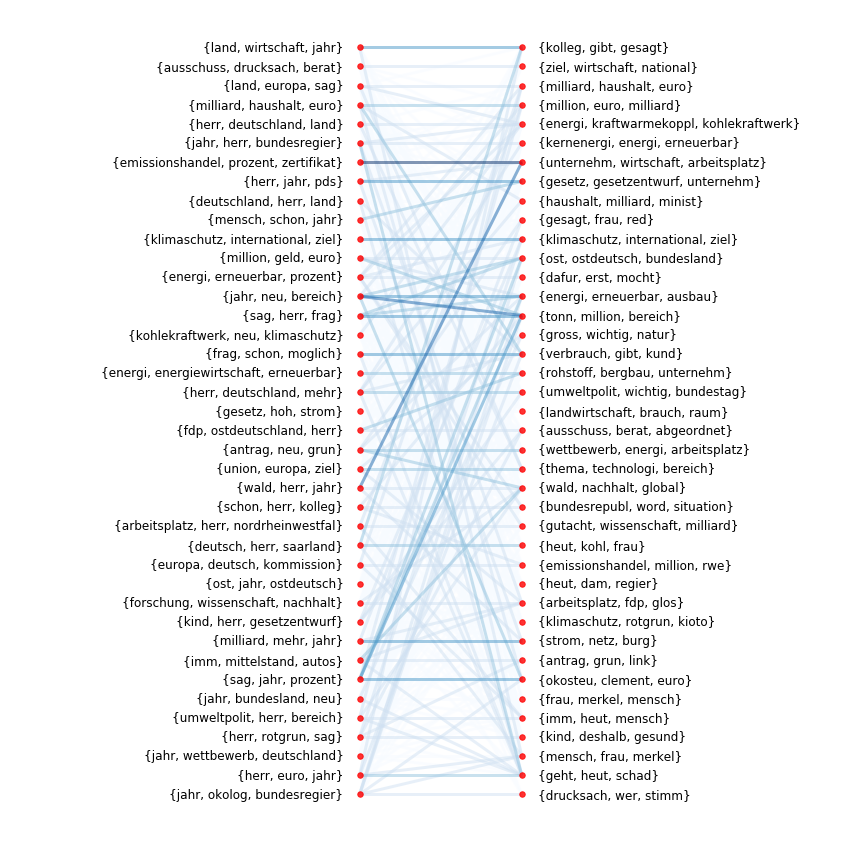

In [44]:
# NMF, stopword = 'deutschland', 'sag', word frequency >= 5
run_id1 = 1063
run_id2 = 1124

topics1 = Topic.objects.filter(run_id=run_id1).order_by('-score')
topics2 = Topic.objects.filter(run_id=run_id2).order_by('-score')

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_Kohle_LD_K{}_stopword_frequency_5_topword_score'.format(K))

### NMF

['run_1125_topics_40', 'scores_1125', 'similarity_1125-1058', 'run_1058_topics_40', 'scores_1058']
C2:C40
matching sum:	212.0
max rows:	222.0
max cols:	230.0


0

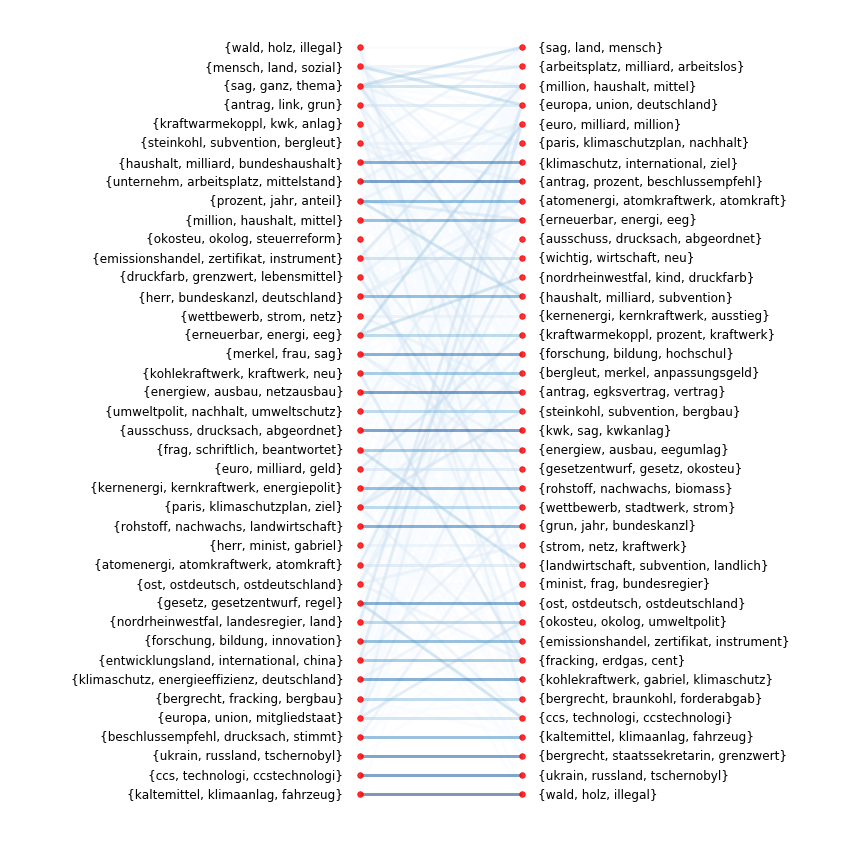

In [46]:
# NMF, stopword = 'herr'
run_id1 = 1058
run_id2 = 1125

topics1 = Topic.objects.filter(run_id=run_id1).order_by('-score')
topics2 = Topic.objects.filter(run_id=run_id2).order_by('-score')

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_Kohle_NM_K{}_stopword_{}_topword_score'.format(K, stopword1[0]))

['run_1058_topics_40', 'scores_1058', 'similarity_1058-1120', 'run_1120_topics_40', 'scores_1120']
C2:C40
matching sum:	229.0
max rows:	246.0
max cols:	243.0


0

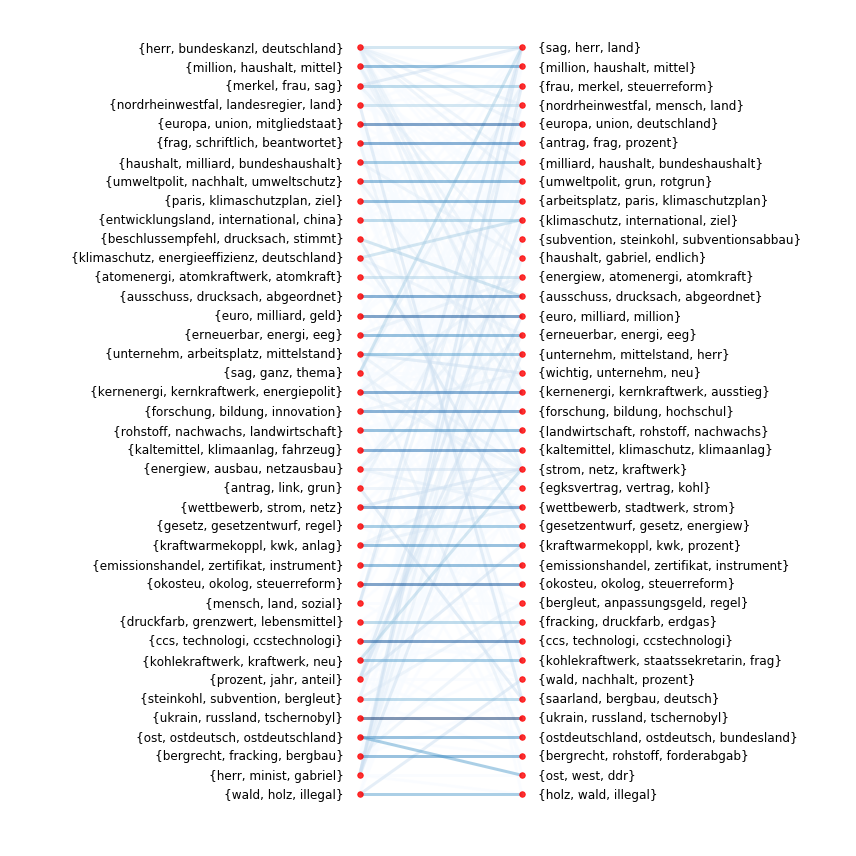

In [33]:
# NMF, stopword = 'jahr'
run_id1 = 1058
run_id2 = 1120

topics1 = Topic.objects.filter(run_id=run_id1).order_by('-score')
topics2 = Topic.objects.filter(run_id=run_id2).order_by('-score')

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_Kohle_NM_K{}_stopword_{}_topword_score'.format(K, stopword2[0]))

['run_1126_topics_40', 'scores_1126', 'similarity_1126-1058', 'run_1058_topics_40', 'scores_1058']
C2:C40
matching sum:	224.0
max rows:	235.0
max cols:	240.0


0

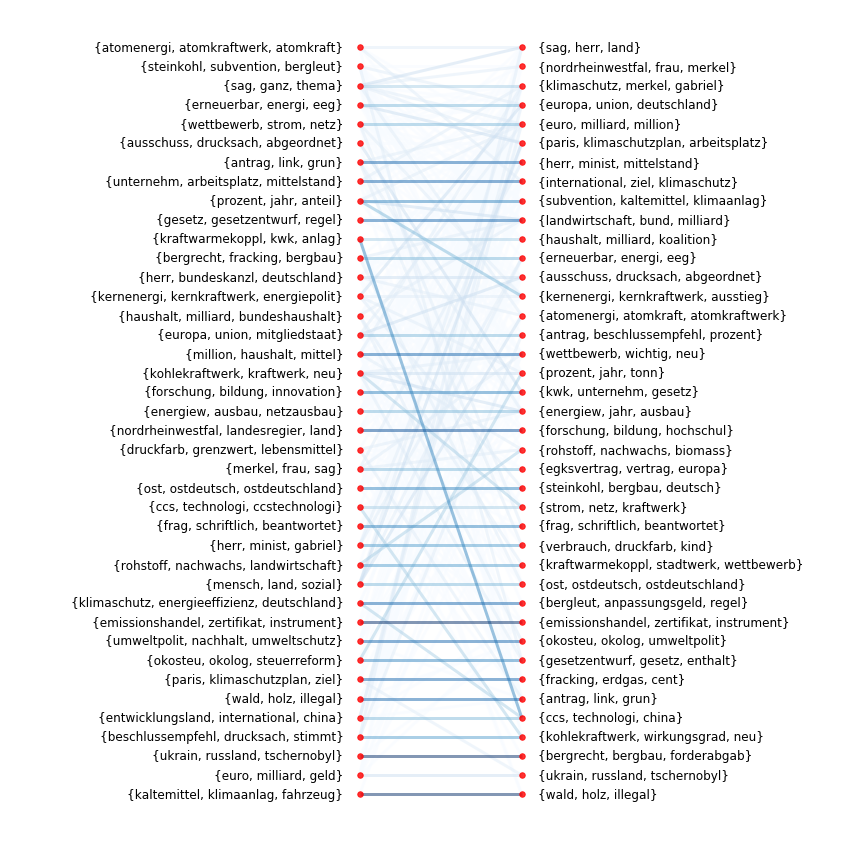

In [45]:
# NMF, stopword = 'mehr'
run_id1 = 1058
run_id2 = 1126

topics1 = Topic.objects.filter(run_id=run_id1).order_by('-score')
topics2 = Topic.objects.filter(run_id=run_id2).order_by('-score')

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_Kohle_NM_K{}_stopword_{}_topword_score'.format(K, stopword3[0]))

['run_1122_topics_40', 'scores_1122', 'similarity_1122-1058', 'run_1058_topics_40', 'scores_1058']
C2:C40
matching sum:	216.0
max rows:	230.0
max cols:	230.0


0

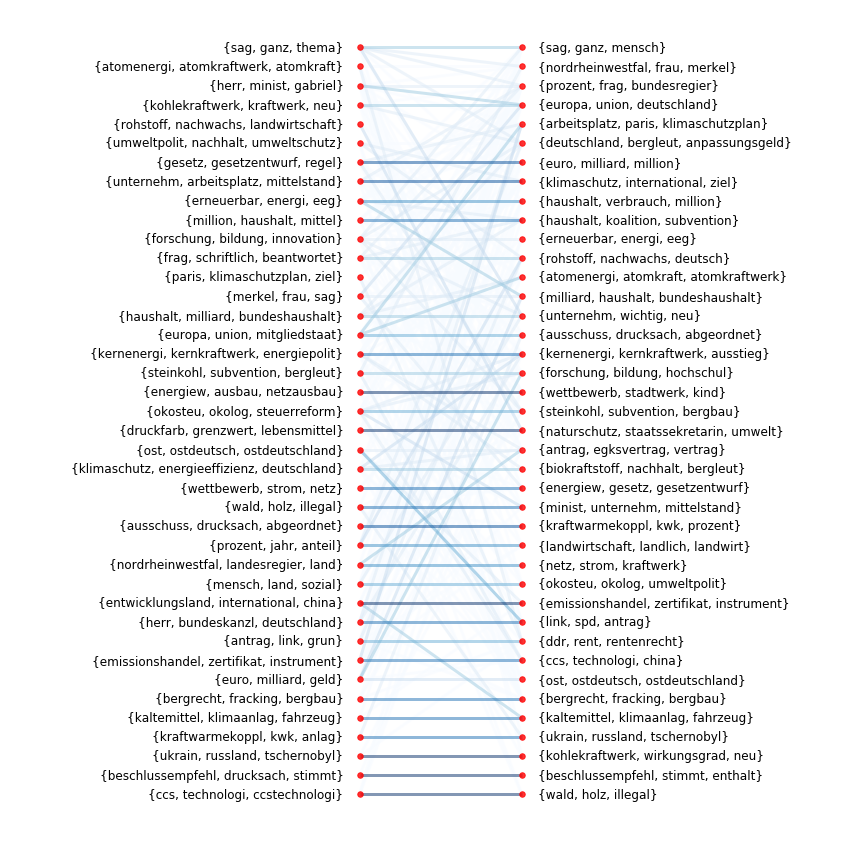

In [37]:
# NMF, stopword = 'herr', 'jahr', 'mehr'
run_id1 = 1058
run_id2 = 1122

topics1 = Topic.objects.filter(run_id=run_id1).order_by('-score')
topics2 = Topic.objects.filter(run_id=run_id2).order_by('-score')

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_Kohle_NM_K{}_stopword_{}_topword_score'.format(K, stopword123))

['run_1123_topics_40', 'scores_1123', 'similarity_1123-1058', 'run_1058_topics_40', 'scores_1058']
C2:C40
matching sum:	227.0
max rows:	239.0
max cols:	244.0


0

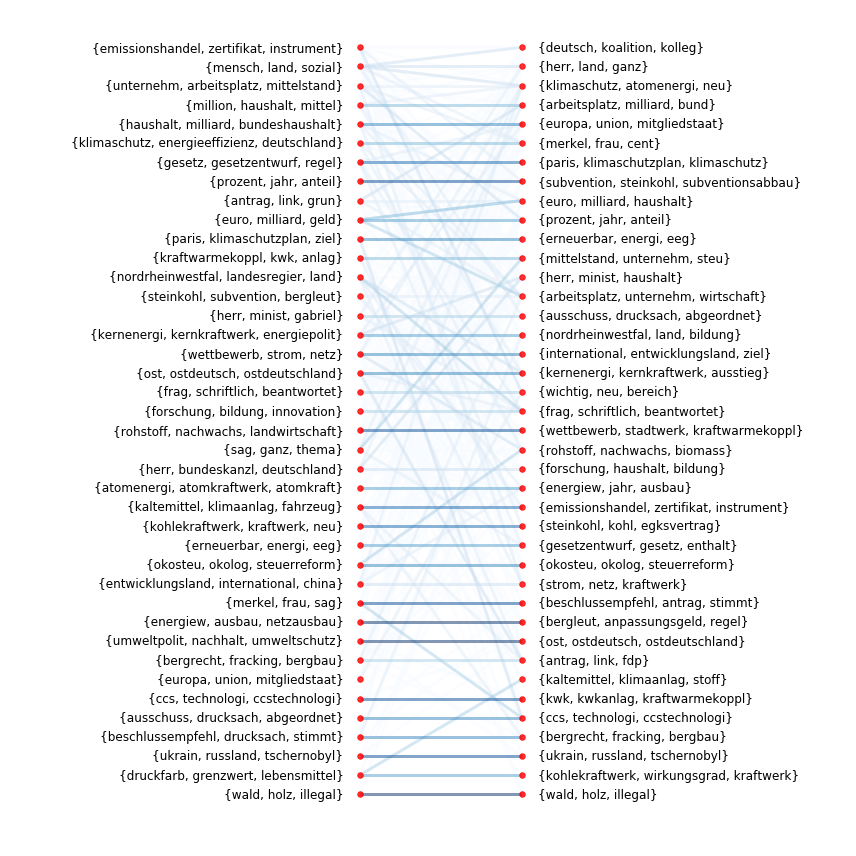

In [41]:
# NMF, stopword = 'deutschland', 'sag', word frequency >= 5
run_id1 = 1058
run_id2 = 1123

topics1 = Topic.objects.filter(run_id=run_id1).order_by('-score')
topics2 = Topic.objects.filter(run_id=run_id2).order_by('-score')

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_Kohle_NM_K{}_stopword_frequency_5_topword_score'.format(K))